https://www.cs.toronto.edu/~kriz/cifar.html


# Uvod

Interesuje nas da li možemo da predviđamo koristeći metod učenja. Istražujemo upotrebu sistema učenja , kao crne kutije, u rešavanju problema rekonstrukcije signala. Istraživaćemo kako se konvolucione neuronske mreže i autoenkoderi ponašaju u zavisnosti od različitih okolnosti.

Rekonstrukcija signala je linearni inverzni problem gde okolnosti nisu dovoljno određene.
Imamo opservaciju $y$ iz $R^m$ i matricu $A$ iz $R^{mxn}$ tako da je $y=Ax_0$ za neko $x_0$ iz $R^n$.
Ovde je $m<n$ pa otud i neodređenost.


Cilj nam je rekonstruišemo $x_0$ ako imamo znanje o $y$ i $A$.
Naravno, ako ne znamo nista o $x_0$, ne postoji garancija da ćemo moći da ga rekonstruišemo, s obzirom na to da je $m<n$ . 
Zato pretpostavljamo da  $x_0$ pripada određenoj klasi signala, npr. podskupu  $R^n$ specifične strukture. Uobičajena pretpostavka je da je  $x_0$ proređen.



   Slika aproksimativno retka kada je predstavljena u odgovarajućoj bazi, kao sto je wavelet baza koja se koristi za rekonstrukciju originalnih podataka uz minimalne gubitke. Metodi garantuju rekonstrukciju  $x_0$ kada je pretpostavka o retkosti tačna.
Međutim, pretpostavka je idealizovana jer  $x_0$ nije uvek sasvim proređen.
Jos bitnije, kada se radi sa specifičnim objektima kao što su slike prirode, može biti više ili manje strukturnih svojstava nego proređenosti, a modelovanje tih struktura nije trivijalno.

Postavlja se pitanje, šta ako možemo da naučimo strukture? I šire, šta ako možemo da naučimo da rekonstruišemo $x_0$ bez ekspilicitnog traženja struktura?









Rekonstrukcija signala se pojavila 2006.godine kada se pokazalo da se rešavanjem običnog konveksnog problema, tj. nalaženjem minimuma funkcije, može rekonstruisati $x_0$, pod pretpostavkom da je $x_0$ dovoljno proređen.
Uveden je iterativni algoritam pod nazivom AMP za rešavanje problema rekonstrukcije signala, sa kojim će se porediti naši rezultati.


Istražujemo upotrebu CNN (konvolutivne neuronske mreže) i VAE (varijacionog autoenkodera) , učenjem zasnovanog na regresiji.
Izbor CNN je intuitivan jer su one uzimaju u obzir prostornu strukturu. 




Koristićemo podatke iz CIFAR 10 i veštački generisane podatke i upoređivate rezultate koje dobijamo.

In [0]:
import pywt # za wavelet
import pickle # da ucitavanje Dataset-a

import numpy as np
import h5py
from matplotlib import pyplot as plt

from keras.layers import *
from keras.models import *
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
import keras.backend as K

from sklearn.model_selection import train_test_split



### Ucitavanje CIFAR-10

In [18]:
def unpickle(file):    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



imdata = None
for i in range(5):
    b = unpickle(''.join(['data_batch_', str(i+1)]))  
    imdata = b[b'data'] if imdata is None else np.vstack((imdata, b[b'data']))

print(imdata.shape)


(50000, 3072)


Svaku sliku u iz CIFAR-10 transformišemo u sivo-skaliranu sliku $\tilde{u}$ zbog jednostavnosti, a zatim primenimo Haar transformaciju $H$ trećeg nivoa tako da je $x_0=H\tilde{u}$ i na ovaj način dobijamo aproksimativno proređeno $x_0$ iz $R^n$. $H$je ortogonalna i čuva sve informacije o $\tilde{u}$.


### Rad sa slikama, konverzija iz RGB u Gray i slicno

In [0]:
# Slika se u CIFAR 10 cuva na sledeci nacin:
# 10000 instanci x 3072 piksela
# 3072 piksela su [1024 crvena, 1024 zelena, 1024 plava]
# Dimenzija slike je 32x32x3 gde prvih 32 odg prvom redu

def convert_to_input_data(in_arr):
    y = np.zeros((in_arr.shape[0], 32, 32, 1))

    for i in range(in_arr.shape[0]):
        u = in_arr[i]
        u_tilda = rgb2gray(u)
        x0 = u_tilda            # x0.shape= (32,32) 
        y[i, :, :, :] = np.reshape(x0, (32, 32, 1))
        
    return y


# Konverzija RGB u sivu sliku ( formula sa neta )
def rgb2gray(rgb):
    rgb = rgb.astype(float)/255.0
    
    # shape mi je pre ovoga (3*1024,1) jer je tako zadata slika u CIFAR-10
    im1 = rgb.reshape((3, 1024))
    r, g, b = im1[0], im1[1], im1[2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    
    return gray # gray.shape ce biti (1,1024) 


# Haar transformacija nad sivom slikom
# https://pywavelets.readthedocs.io/en/latest/ref/2d-decompositions-overview.html
# Preuzeto sa neta
def perform_Haar(u_tilda):
    u_tilda = np.reshape(u_tilda,(32, 32))
    c = pywt.wavedec2(u_tilda, 'haar', level=3)
    arr, slices = pywt.coeffs_to_array(c)
    x0 = arr
    return x0

## Generisani podaci: 

Generišemo $x_0$ iz $R^n$ tako da su ulazi nezavisni i jednako raspodeljeni sa verovatnoćama P($x_0$,i=0)= 0.9i P($x_0$,i=1)=P($x_0$,i= -1)= 0.05. Ovo nam daje veoma proređeno $x_0$.

Za $n$ uzimamo n=32x32=1024 kako bi se slagalo sa dimenzijom slika iz CIFAR-10.
Za ovako generisano $x_0$ pokazano je da AMP i druge prediktivne metode rade dobro.

In [0]:
# https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.choice.html
def create_artificial_data():
    N = 1024
    x0 = np.random.choice([-1, 0, 1], size=1024, p=[0.05, 0.9, 0.05])
    x0 = np.reshape(x0, (32, 32))
    return x0

Generišemo matricu $A$ iz $R^{mxn}$ sa ulazima koji su nezavisni i jednako raspodeljeni iz $N(0,1/m)$.
Matrica $A$ nam je fiksirana za sva treniranja i testiranja koja budemo radili.
Za svako $x_0$ dobijamo $y=Ax_o$, pri čemu $m$ varira.

In [0]:
def create_A(shapeA):
    m, n = shapeA[0], shapeA[1]
    sigma2 = 1/m
    A = np.sqrt(sigma2) * np.random.randn(m, n)
    return A

Kao prvi sloj uzimamo $A^Ty$ i to prosleđujemo neuronskoj mreži.  Na ovaj način obezbeđujemo fiksiranu dimenziju ulaza.

Vrlo je verovatno da je $A$ matrica potpunog ranga pa i $A^Ty$ čuva potpunu informaciju o $y$. 

### Pravljenje modela CNN i VAE modela

In [0]:
def build_CNN_model(image_shape): # mrezi prosledjujemo A^T y :)
    print(image_shape)
    x_input = Input(image_shape)
    x = x_input
    
    for i in range(2):
        x = Conv2D(16, (5, 5), activation='relu', kernel_regularizer=l2(0.01), padding='same')(x) 
        x = Conv2D(16, (5, 5), activation='relu', kernel_regularizer=l2(0.01), padding='same')(x)
        x = BatchNormalization()(x) 
        x = Activation('relu')(x)
        x = MaxPool2D((2,2))(x) 

    x = Flatten()(x)   
    # 1024 da bismo vratili na dimenziju slike 
    x = Dense(1024, activation='linear', kernel_regularizer=l2(0.01))(x) # ne pise nista pa smo stavili linear jer je tako po default-u
    x_kappa = Reshape((32, 32, 1))(x)
    
    model = Model(inputs=x_input, outputs=x_kappa, name = 'CNN')

    return model


# https://keras.io/getting-started/sequential-model-guide/

#Funkcija koja se koristi za konstrukciju latentnog prostora
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
  

  

def build_VAE(image_size): # image_size=32
    
    original_dim = image_size*image_size
    input_shape = (original_dim,)
    latent_dim = 100 
    
    
    # encoder model
    inputs = Input(shape=(image_size, image_size, 1), name='encoder_input')    
    x = Flatten()(inputs)  
    for i in range(2):
        x = Dense(400, kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
    
    #generisanje latentnog prostora
    z_mean = Dense(latent_dim, name='z_mean', kernel_regularizer=l2(0.01))(x)
    z_log_var = Dense(latent_dim, name='z_log_var', kernel_regularizer=l2(0.01))(x)
    
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    
    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
    
    # decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = latent_inputs
    for i in range(2):
        x = Dense(400, kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = Dense(original_dim, kernel_regularizer=l2(0.01))(x)   
    outputs = Reshape((image_size, image_size, 1))(x)
    decoder = Model(latent_inputs, outputs, name='decoder' )
    
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')    

    return vae


  

Funkcija greške (Loss) i metrika za računanje tačnosti

In [0]:
def c_loss(y_true,y_pred):
    diff = (K.batch_flatten(y_true)-K.batch_flatten(y_pred))
    diff = K.pow(diff, 2)
    norm2 = K.sum(diff, axis=(1))
    loss = K.mean(norm2)
    return loss


def metric_acc(y_true, y_pred):
    x_norm_2_pow_2 = (K.batch_flatten(y_true)-K.batch_flatten(y_pred))**2
    x_norm_2_pow_2 = K.sum(x_norm_2_pow_2, axis = 1) 
    
    x0_norm_2_pow_2 = K.batch_flatten(y_true)**2
    x0_norm_2_pow_2 = 0.05*K.sum(x0_norm_2_pow_2, axis = 1)
    
    bool_tensor = K.cast(K.less_equal(x_norm_2_pow_2, x0_norm_2_pow_2), dtype='float32')
    acc = K.mean(bool_tensor)

    return acc       

## Experiment 1: CIFAR-10 Data
- Menjamo m/n odnos. 
- Koristimo matricu A.
- Koristimo Haar transformaciju nad ulaznim slikama


In [24]:
def prepare_sets_exp1(y_lab, A, use_Haar):
    x = np.zeros(y_lab.shape)
    
    for i in range(y_lab.shape[0]):
        x0 = y_lab[i, :, :, 0] #i-ta instanca, dim(x0) = 32 x 32
        if use_Haar is True:
            x0 = perform_Haar(x0)
        y = np.matmul(A, x0)
        x[i, :, :, 0] = np.matmul(A.T, y)
    return x


in_shape = (32, 32, 1)
N_train, N_val, N_test = 2000, 1000, 1000


x_train_val_arr, x_test_arr, y_train_val_arr, y_test_arr = train_test_split(imdata, imdata, 
                                                                          train_size = N_train+N_val, 
                                                                          test_size=N_test,
                                                                           random_state=42)
x_train_arr, x_val_arr, y_train_arr, y_val_arr = train_test_split(x_train_val_arr, y_train_val_arr, 
                                                                  train_size = N_train, 
                                                                  test_size=N_val,
                                                                 random_state=42)

y_train = convert_to_input_data(x_train_arr) # RGB u Grayscale dimenzija 32x32x1
y_val = convert_to_input_data(x_val_arr)
y_test = convert_to_input_data(x_test_arr)



n = 32
cnn_res_exp1 = list()
vae_res_exp1 = list()

for m_div_n in np.linspace(0.3, 1, num=3):
        
    m = int(m_div_n*n)
    print("New m_div_n, n={0}, m={1}".format(n, m))
    
    print("Create A")
    A = create_A((m, n))
   
    print("Prepare train/val/test sets")
    x_train = prepare_sets_exp1(y_train, A, True)
    x_val = prepare_sets_exp1(y_val, A, True)
    x_test = prepare_sets_exp1(y_test, A, True)
        
    print("Build CNN model")
    cnn_model = build_CNN_model(in_shape)
    cnn_model.compile(loss=c_loss, optimizer='adam', metrics=[metric_acc])
    
    print("Start trainig CNN")
    cnn_model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                  epochs=70, batch_size=32, verbose=0, 
                  callbacks = [
                        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0000001, verbose=0), 
                  ])
    res = cnn_model.evaluate(x_test, y_test)
    
    print("Evaluacija CNN modela: {0}".format(res))
    cnn_res_exp1.append((m_div_n, res[1]))    
    
    
    print("Build VEA model")
    vae_model = build_VAE(in_shape[0])
    vae_model.compile(loss=c_loss, optimizer='adam', metrics=[metric_acc])

    print("Start trainig VAE")
    vae_model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                  epochs=200, batch_size=32, verbose=0, 
                  callbacks = [
                        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0000001, verbose=0),
                  ])
    res = vae_model.evaluate(x_test, y_test)
    
    print("Evaluacija VEA modela: {0}".format(res))
    vae_res_exp1.append((m_div_n, res[1]))
    

New m_div_n, n=32, m=9
Create A
Prepare train/val/test sets
Build CNN model
(32, 32, 1)
Start trainig CNN
1000/1000 [==============================] - 1s 1ms/step
Evaluacija CNN modela: [26.188509765625, 0.281]
Build VEA model
Start trainig VAE
1000/1000 [==============================] - 0s 251us/step
Evaluacija VEA modela: [21.123886016845702, 0.43]
New m_div_n, n=32, m=20
Create A
Prepare train/val/test sets
Build CNN model
(32, 32, 1)
Start trainig CNN
1000/1000 [==============================] - 1s 1ms/step
Evaluacija CNN modela: [20.605053573608398, 0.414]
Build VEA model
Start trainig VAE
1000/1000 [==============================] - 0s 244us/step
Evaluacija VEA modela: [21.830819915771485, 0.466]
New m_div_n, n=32, m=32
Create A
Prepare train/val/test sets
Build CNN model
(32, 32, 1)
Start trainig CNN
1000/1000 [==============================] - 1s 1ms/step
Evaluacija CNN modela: [18.366650604248047, 0.496]
Build VEA model
Start trainig VAE
1000/1000 [===========================

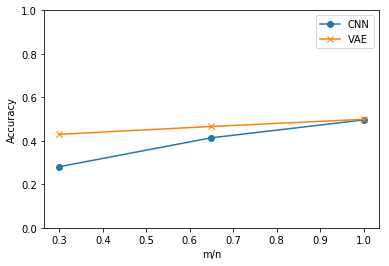

In [25]:
cnn_res_exp1_np = np.array(cnn_res_exp1)
vae_res_exp1_np = np.array(vae_res_exp1)

plt.figure()
plt.plot(cnn_res_exp1_np[:,0], cnn_res_exp1_np[:,1], '-o', label='CNN')
plt.plot(vae_res_exp1_np[:,0], vae_res_exp1_np[:,1], '-x', label='VAE')
plt.ylim([0, 1])
plt.xlabel("m/n")
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Vidimo da sistem učenja ne može da dostigne tačnost blizu 1 kad $m/n$ ->1, za razliku od AMP koji to postiže već za $m/n$~0.7.
Činjenica da sistem brzo dostiže neku preciznost sa porastom $m/n$, koja i dalje nije dovoljno dobra, dovodi do pitanja da li postoji neki fundamentalni problem u našem pristupu rešavanja problema metodom učenja, pa razmatramo 2 hipoteze.


##Hipoteza 1:

Kada je $m/n$ =1, $A$ je kvadratna matrica maksimalnog ranga, pa $y$ treba da sadrži sve informacije o $x_o$. Međutim i u tom slučaju vidimo da tačnost nije velika.
Pretpostavka je da sistem učenja možda mora da uloži veliki napor da bi izneo zaključak o matrici $A$, s obzirom na to da mi ne prosleđujemo znanje o matrici $A$ neuronskoj mreži.
	Veličina matrice $A$ je $mn$, pa čak i za m = 0.05n, imamo 52x103 nepoznatih. 

###Hipoteza 2:
Vidimo da tačnost koju daju CNN i VAE kad je m/n malo, nije trivijalna, za razliku od tačnosti koju daje AMP kad je m/n malo . Naša pretpostavka je da je sistem učenja  u stanju da donese zaključke o nekoj strukturi  slike iz  CIFAR-10 i koristi to znanje za rekonstrukciju slika iz test skupa.
Ovo je osobina po kojoj se razlikuju od prediktivnih metoda kao što je AMP npr.  
Međutim, učenje nam ne nudi optimalnost za razliku od prediktivnih metoda koje to mogu da ostvare.


S ove tačke gledišta, imamo čudnu situaciju.


*   S jedne strane, može se reći da donošenje zaključka o matrici $A$ jeste ključna prepreka.
*   S druge strane, vidimo da sistem učenja ne oponaša prediktivnu proceduru.

Šta je od ovoga tačno?

Videćemo da postoje empirijski dokazi koji podržavaju hipotezu 2 , a u eksperimentu 6 da hipoteza 1 može biti netačna.

Još jedan zaključak: CNN radi bolje od VAE, što ne iznenađuje jer je $x_0$ izveden iz slika.







In [0]:
print(np.array(cnn_res_exp1))

[[0.3   0.284]
 [0.65  0.401]
 [1.    0.429]]


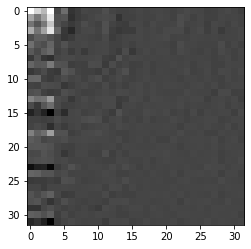

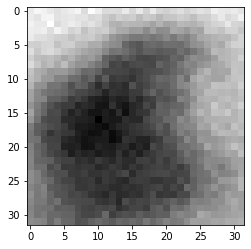

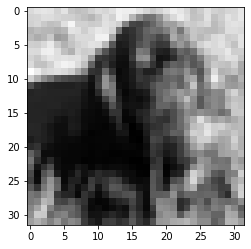

In [0]:
pred_x = cnn_model.predict(x_test)

pred_indx = 21
plt.figure()
plt.imshow(x_test[pred_indx, :, :, 0], cmap='gray')

plt.figure()
plt.imshow(pred_x[pred_indx, :, :, 0], cmap='gray')

plt.figure()
plt.imshow(y_test[pred_indx, :, :, 0], cmap='gray')


In [0]:
res = vae_model.evaluate(x_test[:, :, :, :], y_test[:, :, :, :], batch_size=32)
print(res)

pred_x = vae_model.predict(x_test[:, :, :, :])

pred_indx = 9
plt.figure()
plt.imshow(x_test[pred_indx, :, :, 0], cmap='gray')

plt.figure()
plt.imshow(pred_x[pred_indx, :, :, 0], cmap='gray')

plt.figure()
plt.imshow(y_test[pred_indx, :, :, 0], cmap='gray')


## Experiment 2: Generisani podaci
- Menjamo m/n odnos. 
- Koristimo matricu A.


In [0]:
def prepare_sets_exp2(y_lab, A, use_Haar): #ista f-ja samo se drugacije zove :)
    x = np.zeros(y_lab.shape)
    for i in range(y_lab.shape[0]):
        x0 = y_lab[i, :, :, 0]
        if use_Haar is True:
            x0 = perform_Haar(x0)
        y = np.matmul(A, x0)
        x[i, :, :, 0] = np.matmul(A.T, y)
    return x

  # ovo je jedina razlika u kodu :)
def create_artificial_dataset(N):
    y = np.zeros((N, 32, 32, 1))
    for i in range(N):
        y[i, :, :, 0] = create_artificial_data()
    return y
# --- :)

n = 32
cnn_res_exp2 = list()
vae_res_exp2 = list()

y_train = create_artificial_dataset(N_train)
y_val = create_artificial_dataset(N_val)
y_test = create_artificial_dataset(N_test)

for m_div_n in np.linspace(0.2, 1, num=3):
        
    m = int(m_div_n*n)
    print("New m_div_n, n={0}, m={1}".format(n, m))
    
    print("Create A")
    A = create_A((m, n))
   
    print("Prepare train/val/test sets")
    x_train = prepare_sets_exp2(y_train, A, False)
    x_val = prepare_sets_exp2(y_val, A, False)
    x_test = prepare_sets_exp2(y_test, A, False)
        
    cnn_model_exp2 = build_CNN_model(in_shape)
    cnn_model_exp2.compile(loss=c_loss, optimizer='adam', metrics=[metric_acc])
    
    print("Start trainig")
    cnn_model_exp2.fit(x_train, y_train, validation_data=(x_val, y_val), 
                  epochs=70, batch_size=32, verbose=0, 
                  callbacks = [
                        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0000001, verbose=0),
                  ])
    res = cnn_model_exp2.evaluate(x_test[:, :, :, :], y_test[:, :, :, :])
    
    print("Evaluacija CNN modela: {0}".format(res))
    cnn_res_exp2.append((m_div_n, res[1]))    
    
    print("Build VEA model")
    vae_model_exp2 = build_VAE(in_shape[0])
    vae_model_exp2.compile(loss=c_loss, optimizer='adam', metrics=[metric_acc])
    
    print("Start trainig VAE")
    vae_model_exp2.fit(x_train, y_train, validation_data=(x_val, y_val), 
                  epochs=200, batch_size=32, verbose=0, 
                  callbacks = [
                        ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0000001, verbose=0),
                  ])
    
    print("Evaluacija VAE modela: {0}".format(res))
    res = vae_model_exp2.evaluate(x_test[:, :, :, :], y_test[:, :, :, :])

    vae_res_exp2.append((m_div_n, res[1]))
    

New m_div_n, n=32, m=6
Create A
Prepare train/val/test sets
(32, 32, 1)
Start trainig
1000/1000 [==============================] - 1s 547us/step
Evaluacija CNN modela: [109.23428692626953, 0.0]
Build VEA model
Start trainig VAE
Evaluacija VAE modela: [109.23428692626953, 0.0]
1000/1000 [==============================] - 0s 216us/step
New m_div_n, n=32, m=19
Create A
Prepare train/val/test sets
(32, 32, 1)
Start trainig
1000/1000 [==============================] - 1s 507us/step
Evaluacija CNN modela: [111.89898602294922, 0.0]
Build VEA model
Start trainig VAE
Evaluacija VAE modela: [111.89898602294922, 0.0]
1000/1000 [==============================] - 0s 199us/step
New m_div_n, n=32, m=32
Create A
Prepare train/val/test sets
(32, 32, 1)
Start trainig
1000/1000 [==============================] - 1s 545us/step
Evaluacija CNN modela: [110.01851629638672, 0.0]
Build VEA model
Start trainig VAE
Evaluacija VAE modela: [110.01851629638672, 0.0]
1000/1000 [==============================] - 0s 2

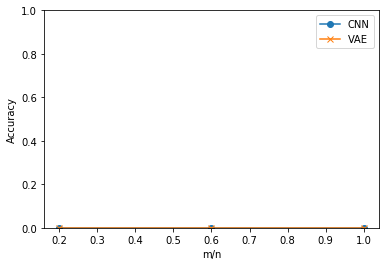

In [0]:
cnn_res_exp2_np = np.array(cnn_res_exp2)
vae_res_exp2_np = np.array(vae_res_exp2)

plt.figure()
plt.plot(cnn_res_exp2_np[:,0], cnn_res_exp2_np[:,1], '-o', label='CNN')
plt.plot(vae_res_exp2_np[:,0], vae_res_exp2_np[:,1], '-x', label='VAE')
plt.ylim([0, 1])
plt.xlabel("m/n")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

U ovom slučaju AMP radi jako dobro, pa bi dobri rezultati sistema učenja ovde, implicirali da mi možemo da vršimo predikciju učenjem.
Međutim,i CNN i VAE dostižu tačnost 0 za svako $m/n$, pa se pitamo gde grešimo.

  S obzirom na to da su CNN i VAE sposobni da uče na podacima iz CIFAR-10, problem bi trebalo da je strukturi $x_o$ koji je veštački generisan.
	Prvo, primetimo da je $x_0$ veoma proređen jer je P($x_0$,i=0)=0.9, a intuitivno, što je ređe  $x_0$, manje informacija treba zaključiti.
Dakle, sistemi učenja izgleda nisu mogli ništa da nauče zbog tolike proređenosti, dok AMP nije imao problema sa tim. Zato pretpostavljamo da je uzrok problema to što su ulazi u  $x_0$ nezavisni.
Podsetimo se da su neuronske mreže univerazlni aproksimatori, tj. da mogu da aproksimiraju svaku razumnu funkciju. 

###AMP, ili prediktivne metode poput nalaženja minimuma konveksne fukncije,  mogu da rade sa jednostavnim ulazima jer se one fokusiraju samo na predikciju , za razliku od CNN i VAE koji se trude da pronađu strukturu a to ne mogu da urade jer su podaci veštački generisani.
Tj. postoji funkcija sa jednostavnim opisom koja radi dobro. (Amp može da nađe tu f-ju.)

Zašto onda naš sistem učenja ne može bar da aproksimira funkciju? Drugim rečima, šta je njima problem da nauče? Setimo se da imamo hipotezu o tome da sistemi treba da nauče da donesu zaključke o matrici $A$.
Ako je ova hipoteza tačna, onda sistem takođe treba da donese zaključke od matrici $A$ radeći i sa podacima iz CIFAR-10, a ipak tamo dostiže razumnu tačnost.
Dakle, zaključujemo da je nezavisna struktura u $x_0$ ono zbog čega CNN i VAE ne uspevaju da nauče. 

###Dolazimo do zaključka da naš sistem učenja podržava određene strukture (koje su u ovom slučaju izvedene iz slike ) i nemoćan je kada je reč o drugim strukturama.


Ako treniramo na podacima iz CIFAR -10, ali testiramo na veštački generisanim podacima, kao što se očekuje, tačnost na trening podacima će biti iznad 0, ali će tačnost na test podacima biti jednaka 0. Vidimo da sistemi učenja radije uče strukture u podacima.


### Eksperiment 3 : CIFAR 10 sa različitim klasama

U posebnom fajlu :) 

### Experiment 4:  CIFAR-10 podaci bez Haar transformacije

Postavlja se pitanje da li imamo neke prednosti ako je $x_0=\tilde{u}$ (sivo skalirana slika) umesto $H\tilde{u}$ (Haar transformacija slike),tj. 

###Da li nam je Haar transformacija korisna.

Naravno, prirodna slika bi trebalo da je različite strukture od one sa Haar transformacijom i očekujemo da se vide promene u rezultatima.


###Ponavaljamo eksperiment 1 
gde menjamo odnos m/n samo što u ovom slučaju ne koristimo Haar-ovu transformaciju za menjanje slika već ih samo množimo sa matricom $A$.



In [0]:
in_shape = (32, 32, 1)
N_train, N_val, N_test = 2000, 1000, 1000


x_train_val_arr, x_test_arr, y_train_val_arr, y_test_arr = train_test_split(imdata, imdata, 
                                                                          train_size = N_train+N_val, 
                                                                          test_size=N_test,
                                                                           random_state=42)
x_train_arr, x_val_arr, y_train_arr, y_val_arr = train_test_split(x_train_val_arr, y_train_val_arr, 
                                                                  train_size = N_train, 
                                                                  test_size=N_val,
                                                                 random_state=42)

y_train = convert_to_input_data(x_train_arr)
y_val = convert_to_input_data(x_val_arr)
y_test = convert_to_input_data(x_test_arr)


n = 32
cnn_res_exp4 = list()
vae_res_exp4 = list()

for m_div_n in np.linspace(0.2, 1, num=5):
        
    m = int(m_div_n*n)
    print("New m_div_n, n={0}, m={1}".format(n, m))
    
    print("Create A")
    A = create_A((m, n))
   
    print("Prepare train/val/test sets")
    x_train = prepare_sets_exp1(y_train, A, False) # False je jedina razlika :)
    x_val = prepare_sets_exp1(y_val, A, False)
    x_test = prepare_sets_exp1(y_test, A, False)
        
    print("Build CNN model")
    cnn_model_exp4 = build_CNN_model(in_shape)
    cnn_model_exp4.compile(loss=c_loss, optimizer='adam', metrics=[metric_acc])
    
    print("Start trainig CNN")
    cnn_model_exp4.fit(x_train, y_train, validation_data=(x_val, y_val), 
                  epochs=80, batch_size=32, verbose=0, 
                  callbacks = [
                        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0000001, verbose=0),
                  ])
    res = cnn_model_exp4.evaluate(x_test[:, :, :, :], y_test[:, :, :, :])

    cnn_res_exp4.append((m_div_n, res[1]))
    
    print("Build VEA model")
    vae_model_exp4 = build_VAE(in_shape[0])
    vae_model_exp4.compile(loss=c_loss, optimizer='adam', metrics=[metric_acc])

    print("Start trainig VAE")
    vae_model_exp4.fit(x_train, y_train, validation_data=(x_val, y_val), 
                  epochs=250, batch_size=32, verbose=0, 
                  callbacks = [
                        ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0000001, verbose=0),
                  ])
    res = vae_model_exp4.evaluate(x_test[:, :, :, :], y_test[:, :, :, :])

    vae_res_exp4.append((m_div_n, res[1]))
    


New m_div_n, n=32, m=6
Create A
Prepare train/val/test sets
Build CNN model
(32, 32, 1)
Start trainig CNN
1000/1000 [==============================] - 1s 815us/step
Build VEA model
Start trainig VAE
1000/1000 [==============================] - 0s 211us/step
New m_div_n, n=32, m=12
Create A
Prepare train/val/test sets
Build CNN model
(32, 32, 1)
Start trainig CNN
1000/1000 [==============================] - 1s 571us/step
Build VEA model
Start trainig VAE
1000/1000 [==============================] - 0s 302us/step
New m_div_n, n=32, m=19
Create A
Prepare train/val/test sets
Build CNN model
(32, 32, 1)
Start trainig CNN
1000/1000 [==============================] - 1s 625us/step
Build VEA model
Start trainig VAE
1000/1000 [==============================] - 0s 319us/step
New m_div_n, n=32, m=25
Create A
Prepare train/val/test sets
Build CNN model
(32, 32, 1)
Start trainig CNN
1000/1000 [==============================] - 1s 627us/step
Build VEA model
Start trainig VAE
1000/1000 [=============

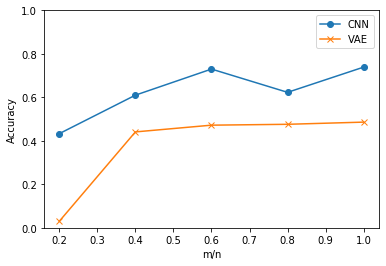

In [0]:
cnn_res_exp4_np = np.array(cnn_res_exp4)
vae_res_exp4_np = np.array(vae_res_exp4)

plt.figure()
plt.plot(cnn_res_exp4_np[:,0], cnn_res_exp4_np[:,1], '-o', label='CNN')
plt.plot(vae_res_exp4_np[:,0], vae_res_exp4_np[:,1], '-x', label='VAE')
plt.ylim([0, 1])
plt.xlabel("m/n")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Izbacivanje Haar transformacije u stvari poboljšava performanse CNN-a.
Ovo ne iznenađuje jer se zna da CNN ostvaruju dobre rezultate na vizuelnim podacima. Ali je zanimljivo da se performanse VAE -a niti poboljšavaju, niti degradiraju.


### Experiment 5:  Još CIFAR-10 podataka za trening

Postavlja se pitanje može li se rešiti problem nezadovoljavajućih performansi pomoću većeg skupa za treniranje.
- Fiksiramo odnos m/n = 0.6
- Povecavamo broj instanci unutar trening seta



 Zaista, povećanje obima skupa za treniranje počev od 2000 poboljšava performanse.Ipak, kad veličina trening skupa postane prevelika, tačnost modela počinje da stagnira.

###Eksperiment 6